## 案例：读取香蕉检测数据集

In [2]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [4]:
def read_data_bananas(is_train=True):
    """读取相加检测数据集的图像和标签"""
    data_dir = '../data/banana-detection'
    # 存储标签信息的csv文件路径
    csv_fname = os.path.join(data_dir, 
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
        # 这里的target是5维的包含（类别索引，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
        
        # unsqueeze用来增加维度，用来表示一个图片至多有几个物体
        # 边缘框存的时候除了高宽，此处选择按[0,1]之间实数存 （也可以直接按像素存，注意分辨）
    return images, torch.tensor(targets).unsqueeze(1) / 256

## 定义香蕉数据集的Dataset

In [5]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + 
              (f' training examples' if is_train else f' validation examples'))

    # 返回一个元组（图片张量，图片标签相关信息：类别、坐标）
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

## 加载香蕉数据集一个批量进内存

In [9]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

图像的shape看起来眼熟，与之前图像分类任务中相同。不同的是，标签包含了更多的信息（批量大小，图像中至多出现多少个物体，类别和边缘框存储占用的位数）

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。 通常来说，图像可能拥有不同数量个边界框；因此，在达到m之前，边界框少于m的图像将被非法边界框填充。 这样，每个边界框的标签将被长度为5的数组表示。 数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。

In [10]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## 展示带有边缘框的图像

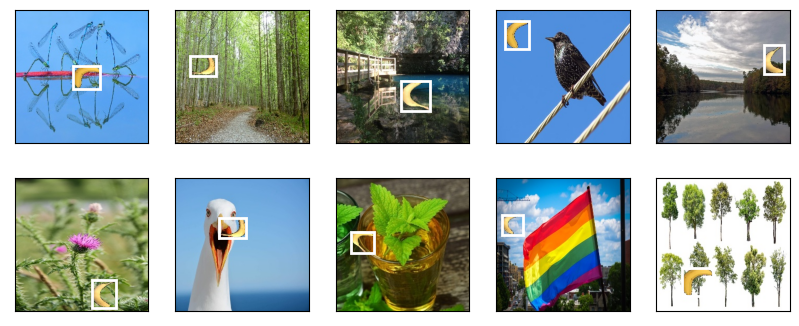

In [11]:
# 此处将张量的通道维放在最后与调用的画图方法有关
# permute方法可以重排张量的维度
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    # 这里坐标乘上edge_size还原成原来的坐标
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

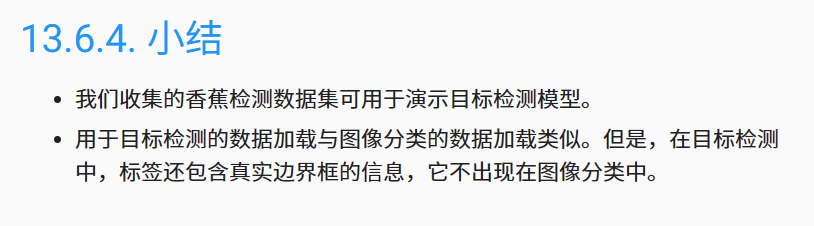